In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For biosignal loading (like in your EDA/ECG scripts):
import biosignalsnotebooks as bsnb
from scipy.signal import butter, filtfilt
import neurokit2 as nk

# Example ML imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import os

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


Aqui están definidas todas las funciones auxiliares que se utilizan para cargar y preprocesar las señales.

In [3]:
def preprocess_eda(raw_signal, sampling_rate):
   
    resolution_bits = 10
    vcc = 3.3
    factor = 0.132  # adapt to your sensor
    signal_us = ((raw_signal / (2**resolution_bits)) * vcc) / factor
    signal_us -= np.mean(signal_us)

    # Example low-pass filter (or band-pass)
    cutoff = 0.5  # 0.5 Hz
    b, a = butter(2, cutoff, btype='low', fs=sampling_rate)
    eda_filt = filtfilt(b, a, signal_us)

    # Example smoothing with a moving average
    window_sec = 5
    window_size = int(window_sec * sampling_rate)
    eda_smoothed = moving_average(eda_filt, window_size)

    # Subsample to 1 Hz
    target_fs = 1
    eda_down = downsample_signal(eda_smoothed, sampling_rate, target_fs)

    # Time array
    time_eda = np.linspace(0, len(eda_down)/target_fs, len(eda_down))
    return eda_down, time_eda, target_fs

def preprocess_ecg(raw_signal, sampling_rate):
    
    resolution_bits = 10
    vcc = 3300
    gain_ecg = 1100
    ecg_mv = (((raw_signal / (2**resolution_bits)) - 0.5) * vcc) / gain_ecg
    ecg_mv -= np.mean(ecg_mv)

    # Band-pass filter to remove drift & high-frequency noise
    lowcut = 0.5
    highcut = 40.0
    b, a = butter(2, [lowcut, highcut], btype='band', fs=sampling_rate)
    ecg_filt = filtfilt(b, a, ecg_mv)

    # Detect R-peaks (example with Neurokit)
    peaks, info = nk.ecg_peaks(ecg_filt, sampling_rate=sampling_rate)
    rpeaks_idx = np.where(peaks["ECG_R_Peaks"] == 1)[0]

    # Convert R-peaks to RR intervals (in seconds)
    rr_intervals = np.diff(rpeaks_idx) / sampling_rate
    # time for midpoint of intervals
    rr_times = (rpeaks_idx[1:] + rpeaks_idx[:-1]) / (2.0 * sampling_rate)

    # Optionally place onto a uniform time grid
    if len(rr_times) > 1:
        uniform_t = np.linspace(rr_times[0], rr_times[-1], len(rr_times))
        rr_uniform = np.interp(uniform_t, rr_times, rr_intervals)
    else:
        # fallback if not enough peaks
        uniform_t = np.array([0])
        rr_uniform = np.array([0])

    # Low-pass filter the RR series to reduce abrupt changes
    if len(rr_uniform) > 2:
        fs_rr = 1.0 / (uniform_t[1] - uniform_t[0])  # approximate
        cutoff_rr = 0.1
        b2, a2 = butter(2, cutoff_rr, btype='low', fs=fs_rr)
        rr_filt = filtfilt(b2, a2, rr_uniform)
    else:
        rr_filt = rr_uniform

    return ecg_filt, rpeaks_idx, uniform_t, rr_filt

def moving_average(data, window_size):
    """Simple moving average smoothing."""
    half_w = window_size // 2
    smoothed = []
    for i in range(len(data)):
        start = max(0, i - half_w)
        end = min(len(data), i + half_w)
        smoothed.append(np.mean(data[start:end]))
    return np.array(smoothed)

def downsample_signal(signal, original_fs, target_fs):
    """Downsample by integer factor."""
    factor = int(original_fs // target_fs)
    return signal[::factor]


Función para crear las ventanas

In [4]:

def create_windows(time_array, signal_array, window_len, step, fs):
    """
    Segment the 'signal_array' into windows of length 'window_len' (s)
    with step 'step' (s), returning (start_time, end_time, segment).
    """
    segs = []
    w_size = int(window_len * fs)
    s_size = int(step * fs)

    idx = 0
    while idx + w_size <= len(signal_array):
        seg_data = signal_array[idx:idx+w_size]
        seg_t0 = time_array[idx]
        seg_tf = time_array[idx+w_size-1]
        segs.append((seg_t0, seg_tf, seg_data))
        idx += s_size

    return segs


Función para extraer las características. En nuestro caso, se extraen la media, la desviación estándar, rango y slope de la señal.


In [5]:

def eda_features(segment):
    """
    Compute features for an EDA segment.
    (Add or remove as needed.)
    """
    mean_val = np.mean(segment)
    std_val  = np.std(segment)
    maximum  = np.max(segment)
    minimum  = np.min(segment)
    rng      = maximum - minimum
    # slope
    slope = np.polyfit(np.arange(len(segment)), segment, 1)[0] if len(segment) > 1 else 0.0
    return [mean_val, std_val, rng, slope]

def rr_features(segment):
    """
    Compute features for an RR-interval segment.
    """
    if len(segment) == 0:
        return [0,0,0,0]
    mean_val = np.mean(segment)
    std_val  = np.std(segment)
    maximum  = np.max(segment)
    minimum  = np.min(segment)
    rng = maximum - minimum
    slope = np.polyfit(np.arange(len(segment)), segment, 1)[0] if len(segment)>1 else 0.0
    return [mean_val, std_val, rng, slope]


Función para anotar las ventanas. En nuestro caso, se anota la ventana como 1 si la ventana contiene mayor número de samples con activación que de samples sin activación. En caso contrario, se anota como 0.

In [6]:

def get_window_label(t0, tf, sr, annotations_df):

    # Convert window boundaries [t0, tf) from seconds -> samples
    sample_start = int(t0 * sr)
    sample_end   = int(tf * sr)

    # Extract the sample indices (column 0) and labels (column 1)
    sample_col = annotations_df.iloc[:, 0]  # sample indices
    label_col  = annotations_df.iloc[:, 1]  # label (0 or 1)

    # Build mask: select rows where the sample index lies in [sample_start, sample_end)
    mask = (sample_col >= sample_start) & (sample_col < sample_end)
    subset_labels = label_col[mask]

    if len(subset_labels) == 0:
        # No annotations in this window => default label = 0
        return 0

    num_ones = (subset_labels == 1).sum()
    num_zeros = (subset_labels == 0).sum()

    # Return 1 if # of ones > # of zeros, else 0
    if num_ones > num_zeros:
        return 1
    else:
        return 0

In [7]:
DATA_DIR = "Grab1"
WINDOW_LEN = 5  # seconds
STEP_LEN   = 1  # seconds

Processing file: Grab1/ESTRES001_20250312_001_02.h5


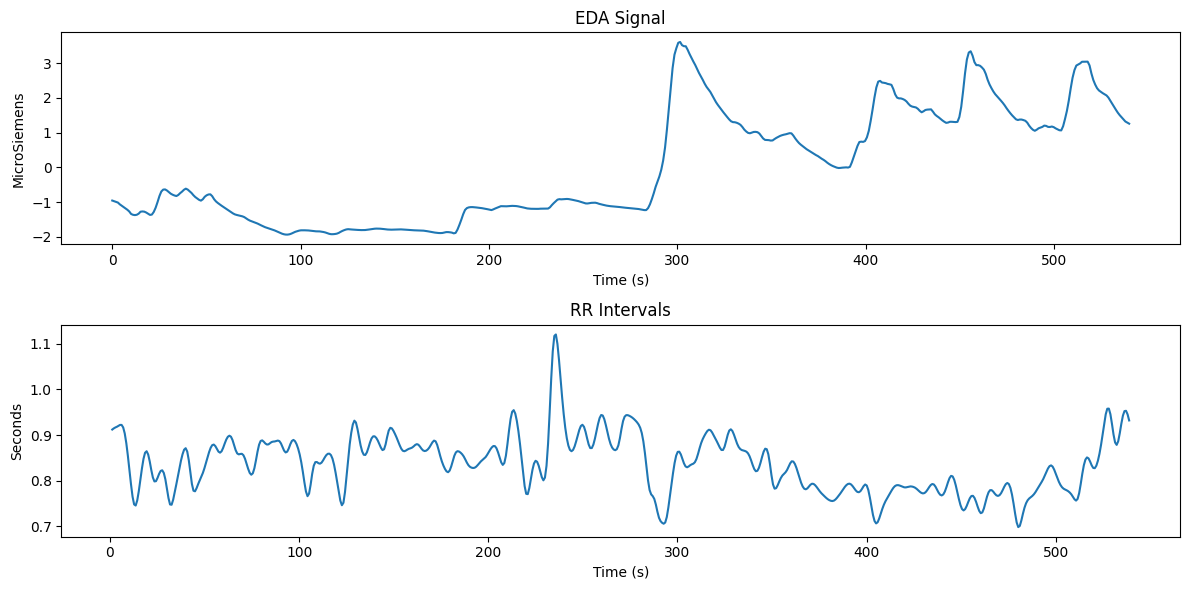

Processing file: Grab1/ESTRES001_20250312_001_05.h5


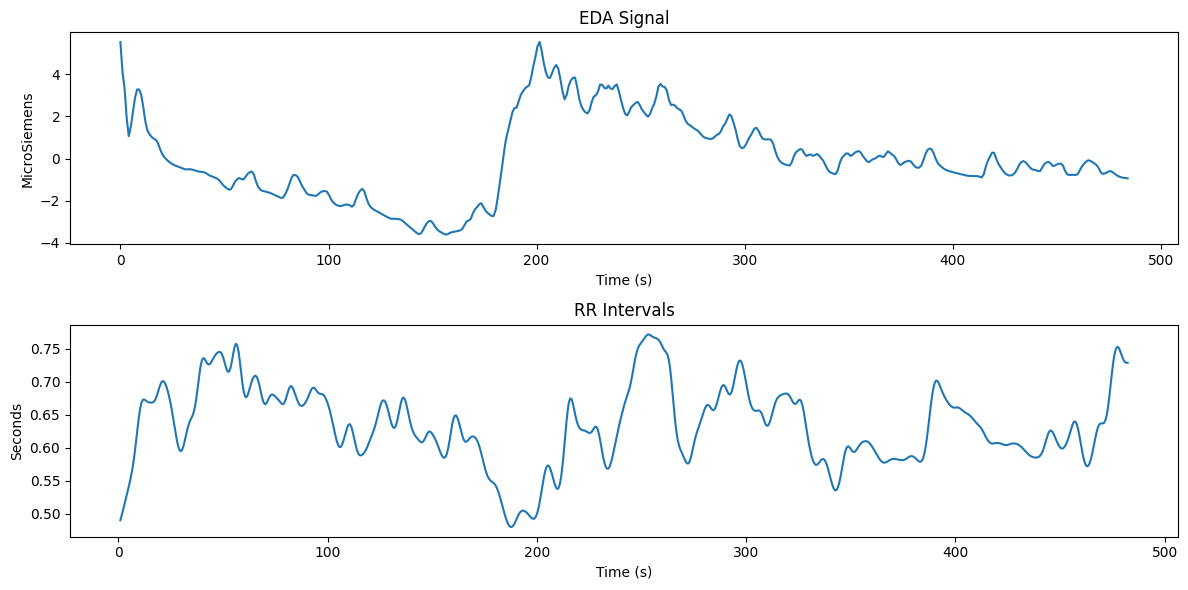

Processing file: Grab1/ESTRES001_20250312_001_03.h5


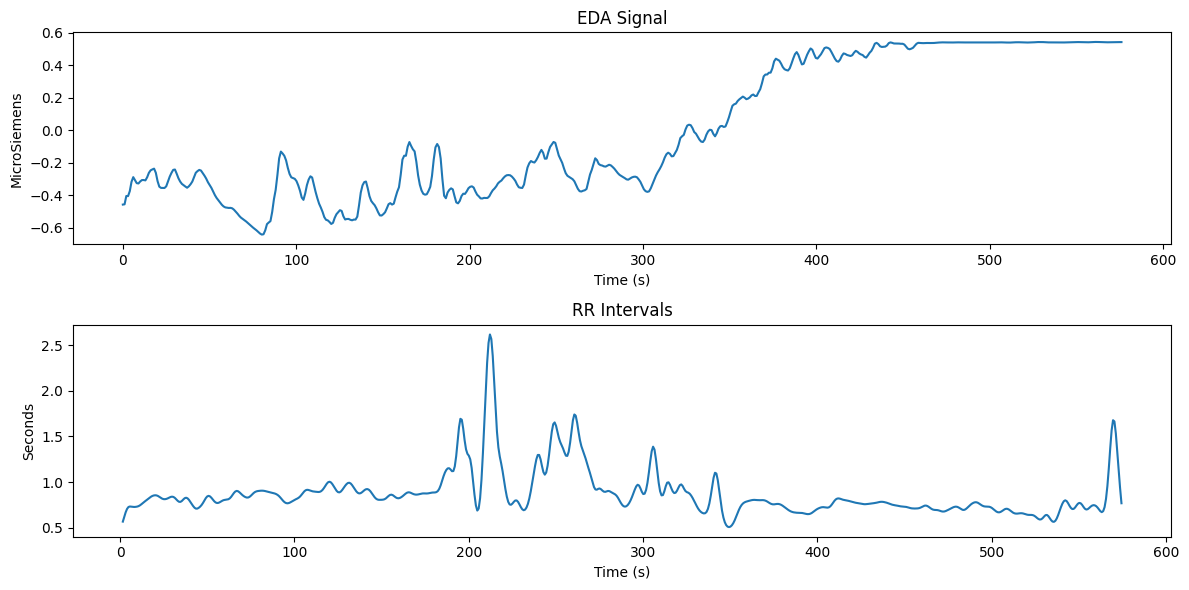

Processing file: Grab1/ESTRES001_20250312_001_04.h5


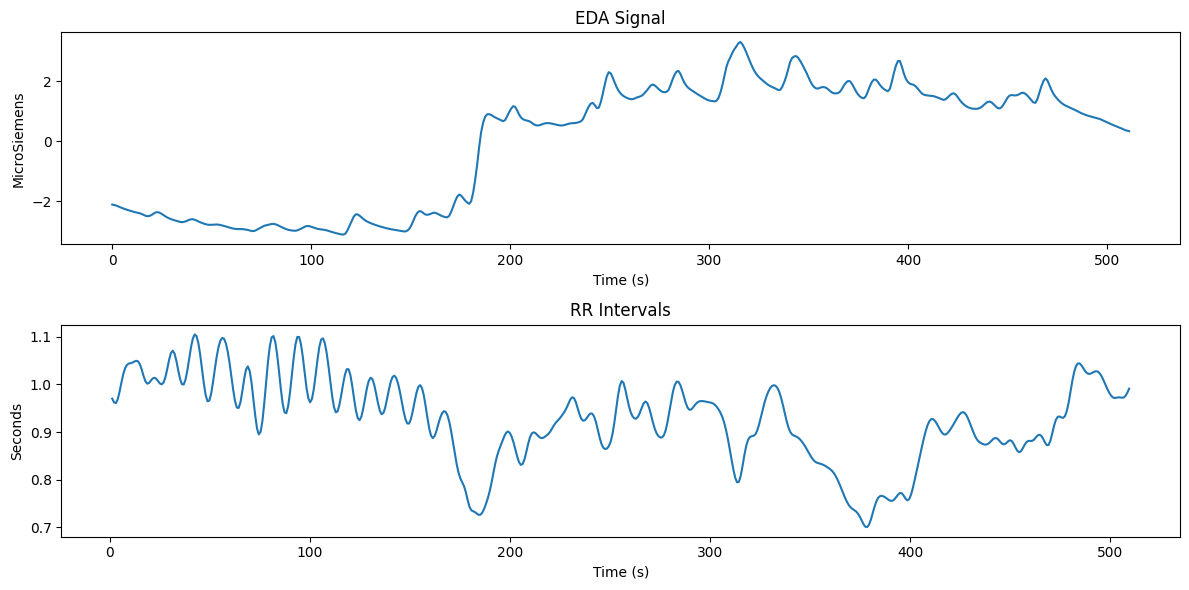

Processing file: Grab1/ESTRES001_20250312_001_01.h5


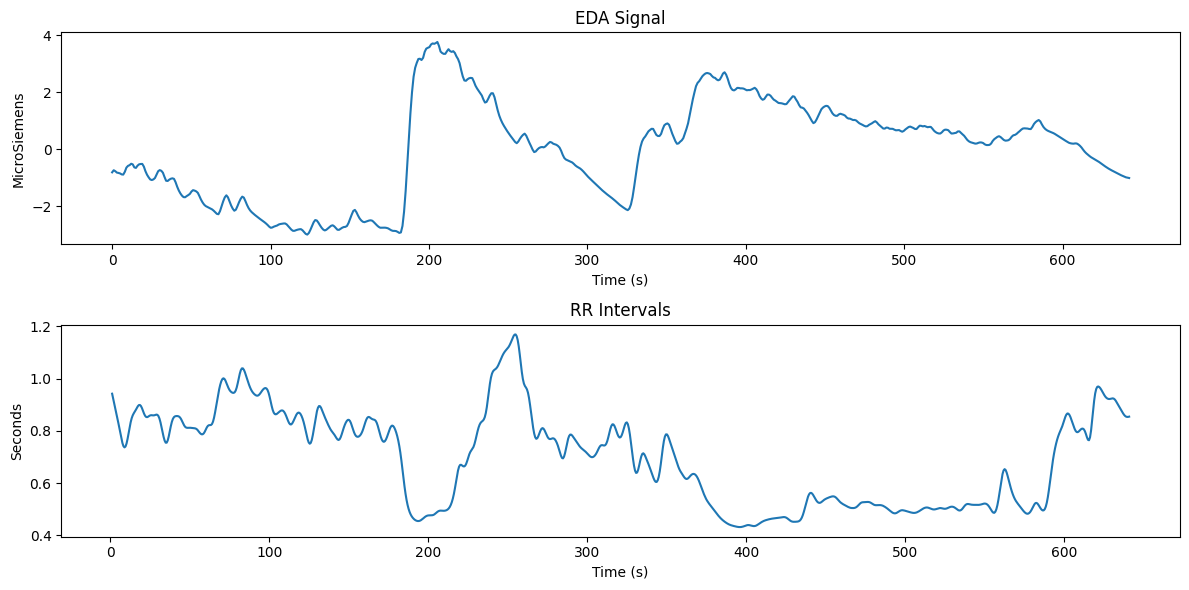

All subjects combined shape: (2733, 10)
   EDA_mean   EDA_std  EDA_range  EDA_slope   RR_mean    RR_std  RR_range  \
0 -0.999555  0.037517   0.108911  -0.025759  0.917335  0.003373  0.010180   
1 -1.029250  0.047738   0.130115  -0.033095  0.919019  0.002800  0.007599   
2 -1.063052  0.055316   0.149177  -0.038871  0.919358  0.002335  0.005601   
3 -1.100855  0.059010   0.169089  -0.041663  0.917167  0.006427  0.018747   
4 -1.142163  0.055189   0.155746  -0.039023  0.911173  0.014437  0.040008   

   RR_slope  label                    file_id  
0  0.001971    0.0  ESTRES001_20250312_001_02  
1  0.001610    0.0  ESTRES001_20250312_001_02  
2  0.000405    0.0  ESTRES001_20250312_001_02  
3 -0.002400    0.0  ESTRES001_20250312_001_02  
4 -0.007180    0.0  ESTRES001_20250312_001_02  


In [8]:
all_subjects_data = []

for file in os.listdir(DATA_DIR):
    if not file.endswith(".h5"):
        continue

    h5_path = os.path.join(DATA_DIR, file)
    base_name = os.path.splitext(file)[0] 
    print(f"Processing file: {h5_path}")

    possible_annot = os.path.join(DATA_DIR, base_name + "_etiquetas.csv")
    if not os.path.isfile(possible_annot):
        print(f"Warning: No annotation file found for {h5_path} (looking for {possible_annot}). Skipping.")
        continue

    # Load the .h5 biosignal
    data_dict, header = bsnb.load(h5_path, get_header=True)

    eda_signal = data_dict["CH2"]
    ecg_signal = data_dict["CH1"]
    sr = header["sampling rate"]  # hopefully the same for both signals, or check each channel if needed

    # Preprocess EDA
    eda_proc, eda_time, eda_fs = preprocess_eda(eda_signal, sr)
    # Preprocess ECG
    ecg_filt, rpeaks, rr_time, rr_filt = preprocess_ecg(ecg_signal, sr)

    """All signals are now preprocessed"""
    #Plot EDA and ECG
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(eda_time, eda_proc)
    plt.title("EDA Signal")
    plt.xlabel("Time (s)")
    plt.ylabel("MicroSiemens")
    plt.subplot(2, 1, 2)
    plt.plot(rr_time, rr_filt)
    plt.title("RR Intervals")
    plt.xlabel("Time (s)")
    plt.ylabel("Seconds")
    plt.tight_layout()
    plt.show()
    # Check if we have enough data
    

    # Window the EDA
    eda_segments = create_windows(eda_time, eda_proc, WINDOW_LEN, STEP_LEN, eda_fs)
    # Window the RR
    if len(rr_time) < 2:
        print(f"Warning: Not enough R-peaks in {file} to build RR. Skipping RR features.")
        rr_segments = []
    else:
        # approximate sampling freq for rr_time (since it's uniform)
        if len(rr_time) > 1:
            fs_rr = 1.0 / (rr_time[1] - rr_time[0])
        else:
            fs_rr = 1.0
        rr_segments = create_windows(rr_time, rr_filt, WINDOW_LEN, STEP_LEN, fs_rr)

    # Load annotation data
    annotations_df = pd.read_csv(possible_annot)

    # Extract features from each EDA window
    X_eda = []
    seg_t_eda = []
    for seg in eda_segments:
        t0, tf, seg_data = seg
        feats = eda_features(seg_data)
        X_eda.append(feats)
        seg_t_eda.append((t0, tf))

    X_eda = np.array(X_eda)

    # Extract features from each RR window
    X_rr = []
    seg_t_rr = []
    for seg in rr_segments:
        t0, tf, seg_data = seg
        feats = rr_features(seg_data)
        X_rr.append(feats)
        seg_t_rr.append((t0, tf))

    X_rr = np.array(X_rr)

    min_len = min(len(X_eda), len(X_rr))
    X_eda = X_eda[:min_len]
    X_rr  = X_rr[:min_len]
    seg_t_eda = seg_t_eda[:min_len]
    # Combine
    X_combined = np.hstack([X_eda, X_rr])

    # Label each window by EDA segment times or a combination
    Y = []
    for i in range(min_len):
        t0_eda, tf_eda = seg_t_eda[i]
        label_i = get_window_label(t0_eda, tf_eda,sr, annotations_df)
        Y.append(label_i)

    Y = np.array(Y)

    # Build a DataFrame for this subject
    # Example feature columns:
    columns_eda = ["EDA_mean","EDA_std","EDA_range","EDA_slope"]
    columns_rr  = ["RR_mean","RR_std","RR_range","RR_slope"]
    columns = columns_eda + columns_rr + ["label"]
    df_subject = pd.DataFrame(np.column_stack([X_combined, Y]), columns=columns)
    df_subject["file_id"] = base_name  # track which file these samples came from

    # Optionally store or append to our master list
    all_subjects_data.append(df_subject)

# Combine all into one DataFrame
combined_df = pd.concat(all_subjects_data, axis=0, ignore_index=True) if all_subjects_data else None

if combined_df is not None:
    print("All subjects combined shape:", combined_df.shape)
    print(combined_df.head())
    # Save to a CSV or pickle, if desired:
    # combined_df.to_csv("all_subjects_features.csv", index=False)
else:
    print("No data processed.")


Savethedataset

In [ ]:
#Save the combined DataFrame to a CSV file
combined_df.to_csv("all_subjects_features.csv", index=False)

Primer train y evaluación para probar 

In [41]:
X_train, X_test, Y_train, Y_test = train_test_split(combined_df.drop("label", axis=1).drop("file_id", axis=1), combined_df["label"], test_size=0.2, random_state=42)

# Optionally scale the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Train a simple classifier, e.g., RandomForest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, Y_train)

# Predict
Y_pred = clf.predict(X_test_scaled)

# Evaluate
acc = accuracy_score(Y_test, Y_pred)
print("Accuracy:", acc)
print("Confusion matrix:\n", confusion_matrix(Y_test, Y_pred))
print("Classification report:\n", classification_report(Y_test, Y_pred))


Accuracy: 0.8811700182815356
Confusion matrix:
 [[437  16]
 [ 49  45]]
Classification report:
               precision    recall  f1-score   support

         0.0       0.90      0.96      0.93       453
         1.0       0.74      0.48      0.58        94

    accuracy                           0.88       547
   macro avg       0.82      0.72      0.76       547
weighted avg       0.87      0.88      0.87       547



Vamos a probar otros algoritmos usando k-fold cross validation.

In [42]:
# k-fold cross-validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(combined_df):
    X_train, X_test = combined_df.drop("label", axis=1).drop("file_id", axis=1).iloc[train_index], combined_df.drop("label", axis=1).drop("file_id", axis=1).iloc[test_index]
    Y_train, Y_test = combined_df["label"].iloc[train_index], combined_df["label"].iloc[test_index]

    # Optionally scale the data
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # Train a simple classifier, e.g., RandomForest
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train_scaled, Y_train)

    # Predict
    Y_pred = clf.predict(X_test_scaled)

    # Evaluate
    acc = accuracy_score(Y_test, Y_pred)
    scores.append(acc)

print("Accuracy:", np.mean(scores))

Accuracy: 0.8053471817640008
